<a href="https://colab.research.google.com/github/oimartin/dog_cat_redux_kernelED/blob/main/reading_in_image_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

## Libraries

In [1]:
import os, cv2, random, shutil
import numpy as np
import pandas as pd
from google.colab import files
from google.colab.output import eval_js
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from time import time
from keras.models import Sequential
from keras import layers
from keras.losses import BinaryCrossentropy, Poisson, SparseCategoricalCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping

from sklearn.metrics import log_loss, brier_score_loss, PrecisionRecallDisplay, RocCurveDisplay, roc_curve

## Load Data with Kaggle API
[*Kaggle API doc*](https://www.kaggle.com/general/74235)

In [2]:
eval_js('google.colab.output.setIframeHeight("500")')

uploaded = files.upload()
!mkdir /root/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!mkdir train_img
!mkdir test_img
!unzip train.zip -d train_img
!unzip test.zip -d test_img/

Streaming output truncated to the last 5000 lines.
  inflating: test_img/test/5499.jpg  
  inflating: test_img/test/55.jpg    
  inflating: test_img/test/550.jpg   
  inflating: test_img/test/5500.jpg  
  inflating: test_img/test/5501.jpg  
  inflating: test_img/test/5502.jpg  
  inflating: test_img/test/5503.jpg  
  inflating: test_img/test/5504.jpg  
  inflating: test_img/test/5505.jpg  
  inflating: test_img/test/5506.jpg  
  inflating: test_img/test/5507.jpg  
  inflating: test_img/test/5508.jpg  
  inflating: test_img/test/5509.jpg  
  inflating: test_img/test/551.jpg   
  inflating: test_img/test/5510.jpg  
  inflating: test_img/test/5511.jpg  
  inflating: test_img/test/5512.jpg  
  inflating: test_img/test/5513.jpg  
  inflating: test_img/test/5514.jpg  
  inflating: test_img/test/5515.jpg  
  inflating: test_img/test/5516.jpg  
  inflating: test_img/test/5517.jpg  
  inflating: test_img/test/5518.jpg  
  inflating: test_img/test/5519.jpg  
  inflating: test_img/test/552.jpg   

# EDA
*Inspired by Jeff Delaney notebook: https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter*

## First Look at Data


In [2]:
"""
Get directory path for all images, just dogs, and just cats
"""
def get_images (directory, type=None):
    if type is None:
        images = [directory + i for i in os.listdir(directory)]
        print(f"There are {len(images)} images")
    else:
        images = [directory + i for i in os.listdir(directory) if type in i]
        print(f"There are {len(images)} {type} images")
    return images

train = '/content/train_img/train/'
test = '/content/test_img/test/'

train_images = get_images(train)
train_dogs = get_images(train, 'dog')
train_cats = get_images(train, 'cat')

test_images = get_images(test)

There are 25000 images
There are 12500 dog images
There are 12500 cat images
There are 12500 images


## First View of Data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


([<matplotlib.axis.XTick at 0x7ff1e2f41050>,
 [Text(0, 0, 'Dog_pic'), Text(0, 0, 'Cat_pic')])

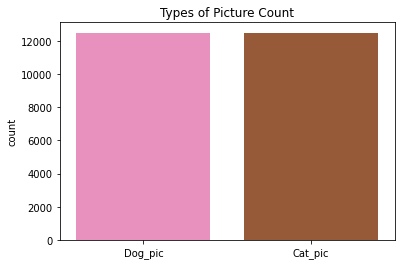

In [3]:
# Create cat/dog label list
labels = []
for img_name in train_images:
    if 'dog' in img_name:
        labels.append(1)
    else:
        labels.append(0)

# View label distribution
sns.set_palette('Set1_r')
sns.countplot(labels).set(title='Types of Picture Count')
plt.xticks(ticks=[0,1], labels=['Dog_pic', 'Cat_pic'])

## Processing Data

In [4]:
# Randomly select dog and cat images to make subset of training images
train_images = random.sample(train_dogs, 10) + random.sample(train_cats, 10)
sample_size = len(train_images)
random.shuffle(train_images)
hmm = train_images[1]
display(hmm[24:])
!mkdir train_subset
for file in train_images:
    shutil.copy(file, f"/content/train_subset/{file[24:]}")

'/cat.4392.jpg'

mkdir: cannot create directory ‘train_subset’: File exists


In [5]:
# Define parameters for images to be processed
ROWS = 75
COLS = 75
CHANNELS = 3

In [6]:
"""
View image and process image for model

"""
def read_image (file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return (cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC))

def prep_data(images):
    count = len(images)
    data = np.ndarray((count,CHANNELS, ROWS, COLS), dtype=np.uint8)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print (f"Processed {i} of {count}")
    return data

train = prep_data(train_images)
print(f"Train shape {train.shape}")

Processed 0 of 20
Train shape (20, 3, 75, 75)


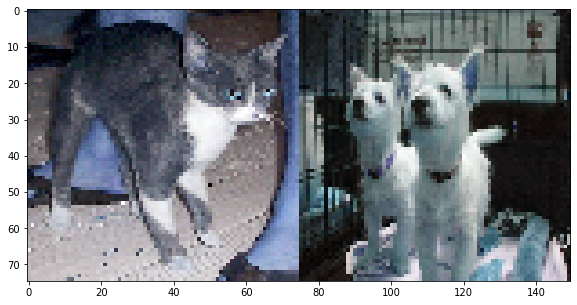

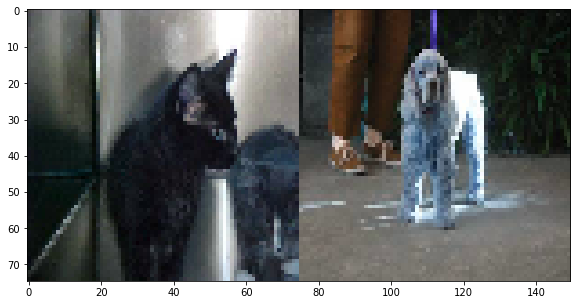

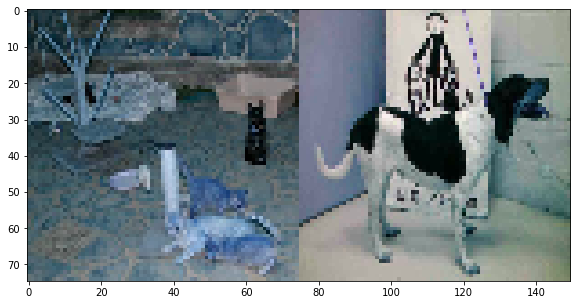

In [7]:
"""
Display images next to each other for certain cat and dog
"""
def show_cats_and_dogs(no, test=False):
  if test is False:
    cat = read_image(train_cats[no])
    dog = read_image(train_dogs[no])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair, cmap='gray')
    plt.show()

  elif test is True:
    test = read_image(test_images[no])
    plt.figure(figsize=(10,5))
    plt.imshow(test, cmap='gray')
    plt.show()
  return
  
for img_id in range(6,9):
    show_cats_and_dogs(img_id)

Text(0.5, 1.0, 'Your Average Dog')

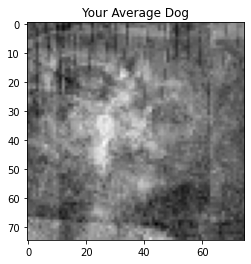

In [8]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg, cmap='gray')
plt.title('Your Average Dog')

Text(0.5, 1.0, 'Your Average Cat')

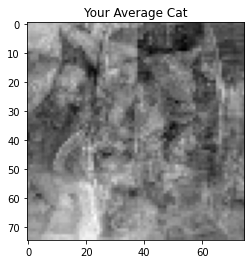

In [9]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg, cmap='gray')
plt.title('Your Average Cat')

# Split Data

In [10]:
X_train, X_test, labels_train, labels_test = train_test_split(train,
                                                                labels[:sample_size],
                                                                test_size=0.2,
                                                                random_state=22)

print(f'''X_train shape {X_train.shape}
labels_train shape {len(labels_train)}
X_test shape {X_test.shape}
labels_test {len(labels_test)}
''')

X_train shape (16, 3, 75, 75)
labels_train shape 16
X_test shape (4, 3, 75, 75)
labels_test 4



In [20]:
X_train = X_train.reshape(X_train.shape[0],ROWS,COLS,3)
X_test = X_test.reshape(X_test.shape[0],ROWS,COLS,3)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

# CNN Models

### Model Functions

In [27]:
def run_model (model, model_name):
  callback = EarlyStopping(monitor='loss', patience=2)
  start = time()
  fitted_model = model.fit(X_train,
                           labels_train,
                           callbacks=[callback])
  end = time()
  runtime = round((end-start), 4)
  print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return runtime

def prediction (fitted_model, x_feat):
  pred = fitted_model.predict(x_feat)
  classes_x = np.argmax(pred,axis=1)
  return pred

def prob_eval (y_true, y_prob, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name],
                   'type': [train_test, train_test],
                   'metric_name': ['bsl', 'log_loss'],
                   'metric' : [round(brier_score_loss(y_true, y_prob), 4),
                               round(log_loss(y_true, y_prob), 4)]})
  display(df)
  return df

def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')

  f, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax0, 
                                   name=f'{model_name} {train_test} ROC_Curve')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax1, 
                                          name=f'{model_name} {train_test} Precision/Recall')
  plt.savefig(f'{model_name}_{train_test}_roc_prec_rec_curves.png')
  plt.show()
  return

def submitted (fitted_model, model_name, test=test):
  pred = fitted_model.predict(test)
  df = pd.DataFrame(pred).rename(columns={0: 'label'}).astype('int64')
  df.index += 1
  df['id'] = df.index
  df = df[['id', 'label']]
  df.to_csv(f"{model_name}_pred.csv", index=False)
  return df

### Test Data

In [22]:
eval_js('google.colab.output.setIframeHeight("100")')


test = prep_data(test_images[:25])
print(f"Test shape {test.shape}")

Processed 0 of 25
Test shape (25, 3, 75, 75)


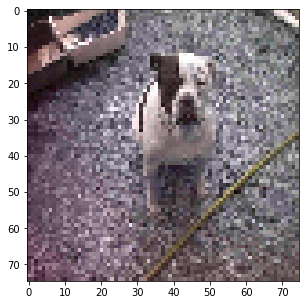

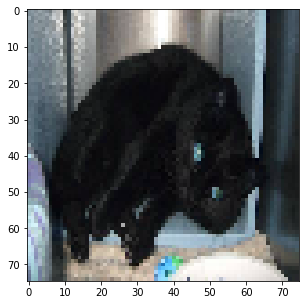

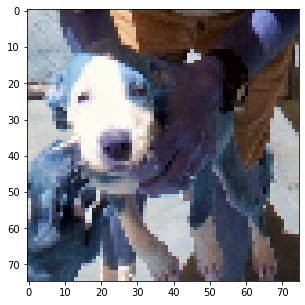

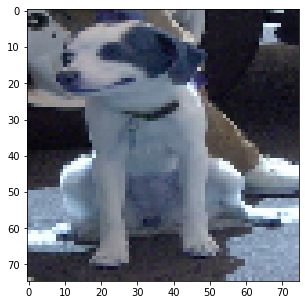

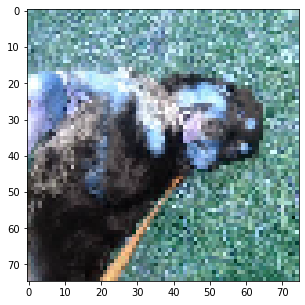

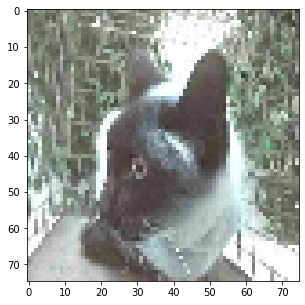

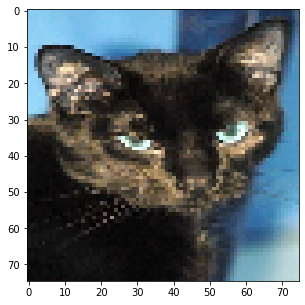

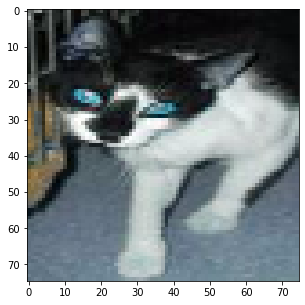

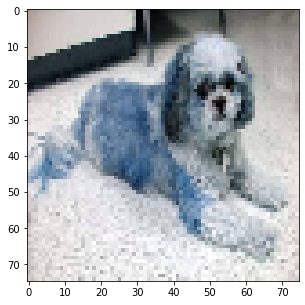

In [23]:
for img_id in range(0,9):
    show_cats_and_dogs(img_id, True)

## Model 1

In [47]:
cnn1 = Sequential([
    layers.Input(shape=(ROWS, COLS, CHANNELS)),
    layers.Conv2D(200, kernel_size=3, activation='relu'),
    layers.Conv2D(100, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation="softmax"),
])
cnn1.compile(optimizer="adam", loss=BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [48]:
cnn1_rt = run_model(cnn1, 'cnn_2d21_d105')
train_prob_cnn1 = prediction(cnn1, X_train)
test_prob_cnn1 = prediction(cnn1, X_test)

1/1 [==============================] - 3s 3s/step - loss: 22.3258 - accuracy: 0.6875
cnn_2d21_d105 took 3.5691 seconds or 0.0595 minutes to run.


### Evaluate First CNN Model

In [49]:
train_prob_cnn1

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


,model_name,type,metric_name,metric
0,cnn1,Train,bsl,0.3125
1,cnn1,Train,log_loss,NaN



  cnn1 for Train Data
  FPR [0. 1.]
  TPR [0. 1.]
  


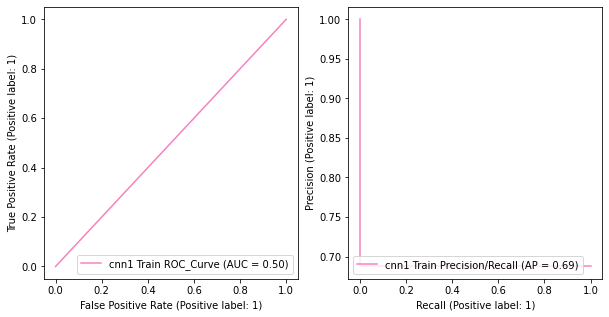

---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


,model_name,type,metric_name,metric
0,cnn1,Test,bsl,0.5
1,cnn1,Test,log_loss,NaN



  cnn1 for Test Data
  FPR [0. 1.]
  TPR [0. 1.]
  


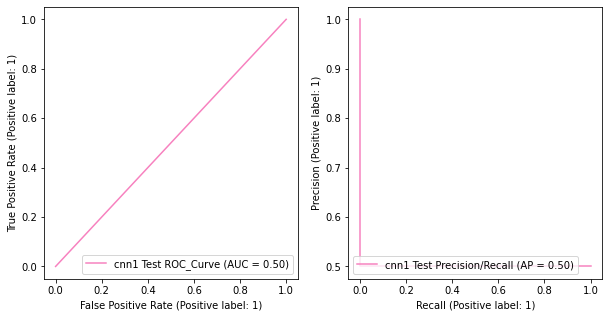

In [50]:
cnn1_train = prob_eval(labels_train, train_prob_cnn1, 'cnn1', 'Train')
eval_classification(train_prob_cnn1, labels_train, X_train, 'cnn1', 'Train')
print("---------------------")
cnn1_test = prob_eval(labels_test, test_prob_cnn1, 'cnn1', 'Test')
eval_classification(test_prob_cnn1, labels_test, X_test, 'cnn1', 'Test')

### Actual Test Results

In [51]:
submitted(cnn1, 'cnn1', test.reshape(test.shape[0], ROWS, COLS, 3))

,id,label
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1
10,10,1
